# Introduction to LangGraph - Module 5: Long-Term Memory

# Pre-requisites

In [2]:
!pip install -qU langgraph langgraph_sdk langchain_openai langchain_core langgraph-prebuilt langchain_community langchain-tavily wikipedia trustcall

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 16.3 MB/s eta 0:00:00


## Chatbot with Memory

**Memory** is a cognitive function that allows people to store, retrieve, and use information to understand their present and future.

**LangGraph Memory Store** is a way to save and retrieve long-term memories. Memory can be categorized as *short-term (within-thread) and *long-term (across-thread)* memory.

In previous modules, we have already known how to set up a thread (checkpointer) for our agents with short-term memory. In this section, we will focus on long-term *semantic memory*, which will be facts about the user. These long-term memories will be used to create a personalized chatbot that can remember facts about the user.

It will save memory *"in the hot path"*(, which means that real-time updates are made immediately available for use in subsequent interactions), as the user is chatting with it.

In [ ]:
from google.colab import userdata
import os
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_TRACING_V2'] = userdata.get('LANGSMITH_TRACING_V2')
os.environ['LANGSMITH_PROJECT'] = userdata.get('LANGSMITH_PROJECT')

## Introduction to the LangGraph Store

The **LangGraph Memory Store** provides a way to store and retrieve information *across thread* in LangGraph. This is an open-source base class for persistent key-value stores:

In [ ]:
import uuid
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

When storing objects (e.g., memories) in the Store, we have
- the `namespace` for the object, a tuple (similar to directories)
- the object `key` (similar to filenames)
- the object `value` (similar to file contents)

Then we use the `put` method to save an object to the store by `namespace` and `key`.

In [ ]:
# Namespace for the memory to save
user_id = '1'
namespace_for_memory = ('memories', user_id)

# Save a memory to namespace as key and value
key = str(uuid.uuid4())

# The value needs to be a dictionary
value = {'sneaker_preference': "I like AJ3"}

# Save the memory
in_memory_store.put(namespace_for_memory, key, value)

We will use `search` method to retrieve objects from the store by `namespace`. This will return a list:

In [ ]:
# Search
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [ ]:
# Metadata
memories[0].dict()

{'namespace': ['memories', '1'],
 'key': '994171bc-5f59-4c4a-b741-99cd29cb73bb',
 'value': {'sneaker_preference': 'I like AJ3'},
 'created_at': '2025-08-21T14:01:52.977742+00:00',
 'updated_at': '2025-08-21T14:01:52.977744+00:00',
 'score': None}

In [ ]:
# The key and value
print(memories[0].key, memories[0].value)

994171bc-5f59-4c4a-b741-99cd29cb73bb {'sneaker_preference': 'I like AJ3'}


We can also use `get` method to retrieve an object by `namespace` and `key`:

In [ ]:
# Get the memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['memories', '1'],
 'key': '994171bc-5f59-4c4a-b741-99cd29cb73bb',
 'value': {'sneaker_preference': 'I like AJ3'},
 'created_at': '2025-08-21T14:01:52.977742+00:00',
 'updated_at': '2025-08-21T14:01:52.977744+00:00'}

## Chatbot with long-term memory

We want our chatbot that has two types of memory:
- *Short-term (within-thread) memory*: Chatbot can persist conversational history and/or allow interruptions in a chat session.
- *Long-term (cross-thread) memory*: Chatbot can remember information about a specific user *across all chat sessions*.

In [ ]:
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

For short-term memory, we will use a checkpointer as we usually did.

For long-term memory, we will use the LangGraph Store:

In [ ]:
# Chat model
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model='gpt-4o', temperature=0)

The chat history will be saved to short-term memory using the checkpointer. The chatbot will reflect on the chat history. It will then create and save a memory to the LangGraph Store.

This memory is accessible in future chat sessions to personalize the chatbot's responses.

In [ ]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.runnables.config import RunnableConfig

from langgraph.store.base import BaseStore

In [ ]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

In [ ]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memory from the store and use it to personalize the chatbot's response"""
    # Get the user ID from the config
    user_id = config['configurable']['user_id']

    # Retrieve memory from the store
    namespace = ('memory', user_id)
    key = 'user_memory'
    existing_memory = store.get(namespace, key)

    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)

    # Respond using memory as well as the chat history
    response = model.invoke(
        [SystemMessage(content=system_msg)] + state['messages']
    )

    return {'messages': response}


def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and save a memory to the store"""
    # Get the user ID from the config
    user_id = config['configurable']['user_id']

    # Retrieve existing memory from the store
    namespace = ('memory', user_id)
    key = 'user_memory'
    existing_memory = store.get(namespace, key)

    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

        # Format the memory in the system prompt
        system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
        new_memory = model.invoke(
            [SystemMessage(content=system_msg)] + state['messages']
        )

        # Overwrite the existing memory in the store
        store.put(namespace, key, {'memory': new_memory.content})

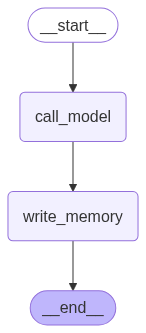

In [ ]:
# Build the graph
builder = StateGraph(MessagesState)

# Nodes
builder.add_node('call_model', call_model)
builder.add_node('write_memory', write_memory)

# Edges
builder.add_edge(START, 'call_model')
builder.add_edge('call_model', 'write_memory')
builder.add_edge('write_memory', END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer and store
graph = builder.compile(
    checkpointer=within_thread_memory,
    store=across_thread_memory
)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

When we interact with the chatbot, we will supply two things:
- Short-term (within-thread) memory: A `thread_id` for persisting the chat history
- Long-term (cross-thread) memory: A `user_id` to namespace long-term memories to the user.

In [ ]:
config = {
    'configurable': {
        'thread_id': '1', # short-term memory
        'user_id': '1',   # long-term memory
    }
}

# User input
input_messages = HumanMessage(content="Hi, my name is Bin")

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Bin
================================== Ai Message ==================================

Hello, Bin! It's nice to meet you. How can I assist you today?


In [ ]:
# User input
input_messages = HumanMessage(content="I like to play basketball in Houston")

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to play basketball in Houston
================================== Ai Message ==================================

That's great, Bin! Houston has a vibrant basketball community. Do you play in a local league or just for fun with friends?


We are using the `MemorySaver` checkpointer for within-thread memory, which saves the chat history to the thread.

We can look at the chat history saved to the thread:

In [ ]:
thread = {'configurable': {'thread_id': '1'}}
state = graph.get_state(thread).values

for m in state['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Bin
================================== Ai Message ==================================

Hello, Bin! It's nice to meet you. How can I assist you today?
================================ Human Message =================================

I like to play basketball in Houston
================================== Ai Message ==================================

That's great, Bin! Houston has a vibrant basketball community. Do you play in a local league or just for fun with friends?


Recall that we compiled the graph with our `store` parameter. In addition, we added a node to the graph (`write_memory`) that reflects on the chat history and saves a memory to the store.

We can see if the memory was saved to the store:

In [ ]:
# Namespace for the memory to save
user_id = '1'
namespace = ('memory', user_id)

existing_memory = across_thread_memory.get(namespace, 'user_memory')
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': "- User's name is Bin."},
 'created_at': '2025-08-21T14:02:33.989653+00:00',
 'updated_at': '2025-08-21T14:02:33.989657+00:00'}

If we kick off a *new thread* with the *same user ID*. We should see that the chatbot remembered the user's profile and used it to personalize the response.

In [ ]:
config = {
    'configurable': {
        'thread_id': '2',
        'user_id': '1'
    }
}

# User input
input_messages = HumanMessage(content="Hi! What's my name?")

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! What's my name?
================================== Ai Message ==================================

Hello! Your name is Bin. How can I assist you today?


We can see that our chatbot still knows my name even though we start a new thread.

# Chatbot with Profile Schema

Our chatbot saved memories as a string. In practice, we often want memories to have a structure. For example, memories can be a single, continuously updated schema.

In our case, we want this to be a single user profile. We will extend our chatbot to save semantic memories to a single user profile.

In [ ]:
from google.colab import userdata
import os
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_TRACING_V2'] = userdata.get('LANGSMITH_TRACING_V2')
os.environ['LANGSMITH_PROJECT'] = userdata.get('LANGSMITH_PROJECT')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

## Defining a user profile schema

We can start by using `TypedDict` to define a user profile schema.

In [ ]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """User profile schema with typed fields"""
    user_name: str
    interests: List[str]

## Saving a schema to the store

The LangGraph Store accepts any Python dictionary as the `value`:

In [ ]:
# TypedDict instance
user_profile: UserProfile = {
    'user_name': 'Bin',
    'interests': ['basketball', 'AI', 'Gaming', 'milktea']
}
user_profile

{'user_name': 'Bin', 'interests': ['basketball', 'AI', 'Gaming', 'milktea']}

We can use the `put` method to save the `TypedDict` to the store.

In [ ]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = '1'
namespace_for_memory = ('memory', user_id)

# Save a memory to namespace as key and value
key = 'user_profile'
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

We can now `search` to retrieve objects from the store by namespace.

In [ ]:
# Search
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['memory', '1'], 'key': 'user_profile', 'value': {'user_name': 'Bin', 'interests': ['basketball', 'AI', 'Gaming', 'milktea']}, 'created_at': '2025-08-21T18:01:02.074414+00:00', 'updated_at': '2025-08-21T18:01:02.074421+00:00', 'score': None}


We can also use `get` to retrieve a specific object by namespace and key.

In [ ]:
# Get the memory by namespace and key
profile = in_memory_store.get(namespace_for_memory, 'user_profile')
profile.value

{'user_name': 'Bin', 'interests': ['basketball', 'AI', 'Gaming', 'milktea']}

## Chatbot with profile schema

In our chatbot, we want to create memories from a user chat. This is where the concept of structured output is useful.

We can use `with_structured_output` method to enforce structured output in the chat model.

We can pass the `UserProfile` schema we created to the `with_strucutred_output` method when we invoke the chat model with a list of messages and get a structured output that conforms to our schema.

In [ ]:
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model='gpt-4o', temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(UserProfile)

# Invoke the model to produce structured output that matches the schema
structured_output = model_with_structure.invoke(
    [HumanMessage("My name is Bin and I like playing basketball.")]
)
structured_output

{'user_name': 'Bin', 'interests': ['playing basketball']}

Now we can use this with our chatbot. This only requires minor changes to the `write_memory` function.

We will use `model_with_structure` to produce a profile that mathces our schema.

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history.
This will be saved for long-term memory. If there is an existing memory, simply update it.
Here is the existing memory (it may be empty): {memory}"""


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memory from the store and use it to personalize the chatbot's response."""
    # Get the user ID from the config
    user_id = config['configurable']['user_id']

    # Retrieve memory from the store
    namespace = ('memory', user_id)
    existing_memory = store.get(namespace, 'user_memory')

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory and the chat history
    response = model.invoke(
        [SystemMessage(content=system_msg)] + state['messages']
    )

    return {'messages': response}


def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and save a memory to the store."""
    # Get the user ID from the config
    user_id = config['configurable']['user_id']

    # Retrieve existing memory from the store
    namespace = ('memory', user_id)
    existing_memory = store.get(namespace, 'user_memory')

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    new_memory = model_with_structure.invoke(
        [SystemMessage(content=system_msg)] + state['messages']
    )

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)

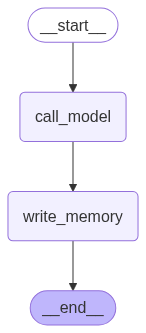

In [ ]:
# Build
builder = StateGraph(MessagesState)

# Nodes
builder.add_node('call_model', call_model)
builder.add_node('write_memory', write_memory)

# Logic
builder.add_edge(START, 'call_model')
builder.add_edge('call_model', 'write_memory')
builder.add_edge('write_memory', END)

# Store for long-term memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term memory
within_thread_memory = MemorySaver()

# Compile
graph = builder.compile(
    checkpointer=within_thread_memory,
    store=across_thread_memory
)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi, my name is Bin and I like playing basketball around Houston and to drink milktea.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Bin and I like playing basketball around Houston and to drink milktea.
================================== Ai Message ==================================

Hi Bin! It's great to meet you. Playing basketball around Houston sounds like a lot of fun, and milk tea is a delicious choice. Do you have a favorite spot for playing basketball or a favorite place to get milk tea?


Now we can check the memory in the store:

In [ ]:
# Namespace for the memory to save
user_id = '1'
namespace = ('memory', user_id)

existing_memory = across_thread_memory.get(namespace, 'user_memory')
existing_memory.value

{'user_name': 'Bin', 'interests': ['playing basketball', 'milktea']}

## When strcutured output fails?

If we have a more complex schema, for example, a Pydantic model that describes a user's preferences for communication and trust fall.

In [ ]:
from typing import List, Optional

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

If we try extraction of this schema using the `with_structured_output` method,

In [ ]:
from pydantic import ValidationError

# Bind schema to model
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    model_with_structure.invoke(f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>""")
except ValidationError as e:
    print(e)

With future foundation model upgrades, this issue may be resolved.

## Trustcall for creating and updating profile schemas

Complex schemas can be difficult to extract. In addition, updating even simple schemas could pose challenges.

Consider our chatbot. We have to regenerate the profile schema *from scratch* each time we chose to save a new memory. This is inefficient, potentially wasting model tokens if the schema contains a lot of information to re-generate each time. Even worse, we may lose information when regenerating the profile from scratch.

[**TrustCall**](https://github.com/hinthornw/trustcall) is able to address this issue. It is an open-source library for updating JSON schemas.

Suppose we have the following conversation,

In [ ]:
# Conversation
conversation = [HumanMessage(content="Hi, I'm Bin."),
                AIMessage(content="Nice to meet you, Bin."),
                HumanMessage(content="I really like playing basketball around Houston.")]

We can use `create_extractor`, passing in the model and our schema as a *tool*.

For example, we can pass a JSON object / Python dictionary or Pydantic model. Under the hood, TrustCall uses `tool_calling` to produce structured output from an input list of messages.

To force TrustCall to produce structured output, we can include the schema name in the `tool_choice` argument.

In [ ]:
from trustcall import create_extractor

# Schema
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(
        description="The user's preferred name"
    )
    interests: List[str] = Field(
        description="A list of the user's interests"
    )


# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile], # our schema
    tool_choice="UserProfile"
)

# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)] + conversation})

When we invoke the extractor, we get
- `messages`: the list of `AIMessages` that contain the tool calls.
- `response`: the resulting parsed tool calls that match our schema.
- `response_metadata`: applicable if updating existing tool calls. It says which of the responses correspond to which of the existing objects.

In [ ]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_AtfogWugwtWcD3YHrZa2RLdE)
 Call ID: call_AtfogWugwtWcD3YHrZa2RLdE
  Args:
    user_name: Bin
    interests: ['playing basketball', 'Houston']


In [ ]:
schema = result["responses"]
schema

[UserProfile(user_name='Bin', interests=['playing basketball', 'Houston'])]

In [ ]:
schema[0].model_dump()

{'user_name': 'Bin', 'interests': ['playing basketball', 'Houston']}

In [ ]:
result["response_metadata"]

[{'id': 'call_AtfogWugwtWcD3YHrZa2RLdE'}]

To **update** the profile, TrustCall takes a set of messages as well as the existing schema.

The main idea is that it prompts the model to produce a JSON Patch to update only the relevant parts of the schema. This is less error-prone than naively overwriting the entire schema.

It is also more efficient since the model only needs to generate the parts of the schema that have changed.

We can save the existing schema as a dictioanry. We can use `model_dump()` to serialize a Pydantic model instance into a dict. We then pass it to the `"existing"` argument along with the schema name, `UserProfile`.

In [ ]:
# Update the conversation
updated_conversation = [
    HumanMessage(content="Hi, I'm Bin."),
    AIMessage(content="Nice to meet you, Bin."),
    HumanMessage(content="I really like playing basketball around Houston."),
    AIMessage(content="Houston is a awesome city! Where do you go after playing?"),
    HumanMessage(content="I really like to go and grab milktea after playing."),]

# Update the instruction
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke(
    {"messages": [SystemMessage(content=system_msg)] + updated_conversation},
    {"existing": {"UserProfile": schema[0].model_dump()}}
)

In [ ]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_LbywK6uEe7o4S6Cw4Dt1N7zq)
 Call ID: call_LbywK6uEe7o4S6Cw4Dt1N7zq
  Args:
    user_name: Bin
    interests: ['basketball', 'milktea', 'Houston']


In [ ]:
result["response_metadata"]

[{'id': 'call_LbywK6uEe7o4S6Cw4Dt1N7zq'}]

In [ ]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': 'Bin', 'interests': ['basketball', 'milktea', 'Houston']}

Now we can test TrustCall on the complex schema we used earlier:

In [ ]:
bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

result = bound.invoke(
    f"""Extract the preferences from the following conversation:
<convo>
{conversation}
</convo>"""
)

# Extract the preferences
result["responses"][0]

TelegramAndTrustFallPreferences(pertinent_user_preferences=UserPreferences(communication_preferences=CommunicationPreferences(telegram=TelegramPreferences(preferred_encoding=[OutputFormat(preference='standard encoding', sentence_preference_revealed='I need to send a message about our trust fall exercise.')], favorite_telegram_operators=None, preferred_telegram_paper=None), morse_code=MorseCode(preferred_key_type=[OutputFormat(preference='straight key', sentence_preference_revealed='I love using a straight key.')], favorite_morse_abbreviations=None), semaphore=Semaphore(preferred_flag_color=None, semaphore_skill_level=None)), trust_fall_preferences=TrustFallPreferences(preferred_fall_height=[OutputFormat(preference='higher', sentence_preference_revealed="Tell him I'm ready for a higher fall.")], trust_level=None, preferred_catching_technique=[OutputFormat(preference='diamond formation', sentence_preference_revealed='I prefer the diamond formation for catching.')])))

## Chatbot with profile schema updating

Now we can bring TrustCall into our chatbot to create and update a memory profile.

In [ ]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END

from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore


# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [ ]:
# Schema
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")


# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", # enforce use of the UserProfile tool
)

In [ ]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke(
        [SystemMessage(content=system_msg)] + state["messages"]
    )

    return {"messages": response}


def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and save a memory to the store."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None

    # Invoke the extractor
    result = trustcall_extractor.invoke(
        {"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"], "existing": existing_profile})

    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

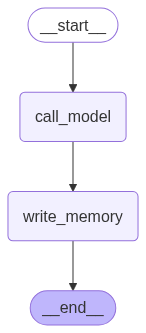

In [ ]:
# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi, my name is Bin")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Bin
================================== Ai Message ==================================

Hello, Bin! It's nice to meet you. How can I assist you today?


In [ ]:
# User input
input_messages = [HumanMessage(content="I like playing basketball around Houston")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like playing basketball around Houston
================================== Ai Message ==================================

That's great to hear, Bin! Houston has some fantastic spots for basketball. Do you have a favorite court or place where you like to play?


In [ ]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'Bin',
  'user_location': 'Houston',
  'interests': ['playing basketball']},
 'created_at': '2025-08-21T18:43:35.106707+00:00',
 'updated_at': '2025-08-21T18:43:35.106709+00:00'}

In [ ]:
# The user profile saved as a JSON object
existing_memory.value

{'user_name': 'Bin',
 'user_location': 'Houston',
 'interests': ['playing basketball']}

In [ ]:
# User input
input_messages = [HumanMessage(content="I also enjoy drinking milktea")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy drinking milktea
================================== Ai Message ==================================

Milk tea is a delicious treat! Do you have a favorite milk tea shop in Houston, or a particular flavor you enjoy the most?


In [ ]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="What milktea do you recommend for me around my area?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What milktea do you recommend for me around my area?
================================== Ai Message ==================================

In Houston, you have a variety of great milk tea options to choose from. Here are a few popular spots you might enjoy:

1. **The Teahouse Tapioca & Tea** - They have a wide range of milk tea flavors and toppings. Their classic milk tea is always a good choice.

2. **Sharetea** - Known for their authentic Taiwanese milk tea, you might want to try their Hokkaido Pearl Milk Tea or the Okinawa Pearl Milk Tea.

3. **Gong Cha** - Offers a variety of milk teas with customizable sugar and ice levels. Their Earl Grey Milk Tea with 3J (pearl, pudding, and herbal jelly) is a favorite.

4. **Kung Fu Tea** - They have a great selection of milk teas, and their Taro Milk Tea is quite popular.

5. **Tea Top** - Offers a unique selection of milk teas, and their Brown Sugar Milk Tea is a mu

We can see that even though we start a new thread (no short-term memory), our chatbot still knows I am in Houston.

# Chatbot with Collection Schema

Sometimes we want to save memories to a collection rather than single profile. In this section, we will update our chatbot to save memories to a collection.

In [3]:
from google.colab import userdata
import os
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_TRACING_V2'] = userdata.get('LANGSMITH_TRACING_V2')
os.environ['LANGSMITH_PROJECT'] = userdata.get('LANGSMITH_PROJECT')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

## Defining a collection schema

Instead of storing user information in a fixed profile structure, we will create a flexible collection schema to store memories about user interaction.

Each memory will be stored as a separate entry with a single `content` field for the main information we want to remember.

This approach allows us to build an open-ended collection of memories that can grow and change as we learn more about the user.

In [20]:
# Define a collection schema
from pydantic import BaseModel, Field


class Memory(BaseModel):
    content: str = Field(
        description="The main content of the memory. For example: User expressed interest in learning about French."
    )


class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(
        description="A list of memories about the user"
    )

In [21]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(MemoryCollection)

# Invoke the model to produce structured output that matches the schema
memory_collection = model_with_structure.invoke(
    [HumanMessage(content="My name is Bin. I like playing basketball!")]
)
memory_collection.memories

[Memory(content="User's name is Bin."),
 Memory(content='User likes playing basketball.')]

We can use `model_dump()` to serialize a Pydantic model instance into a Python dictionary.

In [22]:
memory_collection.memories[0].model_dump()

{'content': "User's name is Bin."}

We can save dictionary representation of each memory to the store.

In [23]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = '1'
namespace_for_memory = ('memories', user_id)

# Save a memory to namespace as key and value
for memory in memory_collection.memories:
    key = str(uuid.uuid4())
    value = memory.model_dump()
    in_memory_store.put(namespace_for_memory, key, value)

Search for memories in the store:

In [24]:
# Search
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['memories', '1'], 'key': '67e958ac-a59a-482c-8078-d8f7da23ae03', 'value': {'content': "User's name is Bin."}, 'created_at': '2025-08-23T15:18:16.862344+00:00', 'updated_at': '2025-08-23T15:18:16.862347+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': 'bf1b8328-fe02-41c0-ac74-fbe4b2b40962', 'value': {'content': 'User likes playing basketball.'}, 'created_at': '2025-08-23T15:18:16.862383+00:00', 'updated_at': '2025-08-23T15:18:16.862384+00:00', 'score': None}


## Updating collection schema

In previous section, we saw the challenges with updating a profile schema. Here, we want the ability to update the collection with new memories as well as update existing memories in the collection.

We will also show and use `TrustCall` to update a collection. This enables both addition of new memories as well as updating existing memories in the collection.

We will first define a new extractor with TrustCall. We will provide the schema for each memory, `Memory`. Then we can supply `enable_inserts=True` to allow the extractor to insert new memories to the collection.

In [25]:
from trustcall import create_extractor

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True
)

In [26]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Bin."),
                AIMessage(content="Nice to meet you, Bin."),
                HumanMessage(content="I had a great pickup basketball game this morning in Houston.")]

# Invoke the extractor
result = trustcall_extractor.invoke(
    {"messages": [SystemMessage(content=instruction)] + conversation}
)

In [27]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_4ynz1MGSLop22pRRPlmTd8b1)
 Call ID: call_4ynz1MGSLop22pRRPlmTd8b1
  Args:
    content: Bin had a great pickup basketball game in Houston this morning.


In [28]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]:
    print(m)

content='Bin had a great pickup basketball game in Houston this morning.'


In [29]:
# Metadata contains the tool call
for m in result["response_metadata"]:
    print(m)

{'id': 'call_4ynz1MGSLop22pRRPlmTd8b1'}


In [30]:
# Update the conversation
updated_conversation = [
    AIMessage(content="That's great, did you do after?"),
    HumanMessage(content="I went back home and had a protein shake"),
    AIMessage(content="What else is on your mind?"),
    HumanMessage(content="I was thinking about taking a nap.."),
]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We will save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Bin had a great pickup basketball game in Houston this morning.'})]

In [31]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor.invoke(
    {
        "messages": updated_conversation,
        "existing": existing_memories
    }
)

In [32]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_g5bdXHOJzgKDWTKZoSDOhXTI)
 Call ID: call_g5bdXHOJzgKDWTKZoSDOhXTI
  Args:
    content: Bin had a great pickup basketball game in Houston this morning. After the game, he went back home, had a protein shake, and thought about taking a nap.


In [33]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]:
    print(m)

content='Bin had a great pickup basketball game in Houston this morning. After the game, he went back home, had a protein shake, and thought about taking a nap.'


In [34]:
# Metadata contains the tool call
for m in result["response_metadata"]:
    print(m)

{'id': 'call_g5bdXHOJzgKDWTKZoSDOhXTI', 'json_doc_id': '0'}


## Chatbot with collection schema updating

Now we will bring TrustCall into our chatbot to create and update a memory collection.

In [35]:
from IPython.display import Image, display
import uuid

from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, SystemMessage, merge_message_runs
from langchain_core.runnables.config import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Memory schema
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

In [36]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user.

You have a long term memory which keeps track of information you learn about the user over time.

Current Memory (may include updated memories from this conversation):

{memory}"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction.

Use the provided tools to retain any necessary memories about the user.

Use parallel tool calling to handle updates and insertions simultaneously:"""


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # Respond using memory as well as the chat history
    response = model.invoke(
        [SystemMessage(content=system_msg)] + state["messages"]
    )

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = (
        [(existing_item.key, tool_name, existing_item.value)
        for existing_item in existing_items]
        if existing_items
        else None
    )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))

    # Invoke the extractor
    result = trustcall_extractor.invoke(
        {
            "messages": updated_messages,
            "existing": existing_memories
        }
    )

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(
            namespace,
            rmeta.get("json_doc_id", str(uuid.uuid4())),
            r.model_dump(mode="json"),
        )

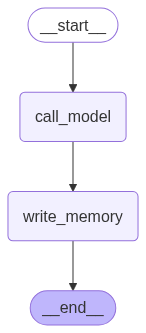

In [40]:
# Build
builder = StateGraph(MessagesState)
# Node
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
# Logic
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [41]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {
    "configurable": {"thread_id": "1", "user_id": "1"}
}

# User input
input_messages = HumanMessage(content="Hi, my name is Bin")

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Bin
================================== Ai Message ==================================

Hi Bin! It's great to meet you. How can I assist you today?


In [42]:
# User input
input_messages = HumanMessage(content="I like playing basketball around Houston")

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like playing basketball around Houston
================================== Ai Message ==================================

That's awesome, Bin! Houston has some great spots for basketball. Do you have a favorite court or place where you like to play?


In [43]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '1'], 'key': 'c5717b02-1cea-4da2-8592-9b655b6bbd4b', 'value': {'content': "User's name is Bin."}, 'created_at': '2025-08-23T15:24:56.101615+00:00', 'updated_at': '2025-08-23T15:24:56.101617+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': '9f38ab40-5400-44f6-9bfe-96e658479917', 'value': {'content': 'User likes playing basketball around Houston.'}, 'created_at': '2025-08-23T15:24:58.409647+00:00', 'updated_at': '2025-08-23T15:24:58.409649+00:00', 'score': None}


In [44]:
# User input
input_messages = HumanMessage(content="I also enjoy drinking milktea")

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy drinking milktea
================================== Ai Message ==================================

Milk tea is delicious! Do you have a favorite flavor or place where you like to get your milk tea in Houston?


In [45]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="What milktea do you recommend for me nearby?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What milktea do you recommend for me nearby?
================================== Ai Message ==================================

Since you're in Houston and enjoy milk tea, there are some great options you might want to try. If you haven't already, you could check out The Teahouse Tapioca & Tea, which has a variety of flavors. Their classic milk tea is always a good choice, but if you're feeling adventurous, you might want to try their Thai milk tea or taro milk tea. Another popular spot is Gong Cha, where you can customize your drink with different toppings and sweetness levels. Do any of these sound good to you?


# Memory Agent

We have created a chatbot that serves semantic memories to a single user profile or collection by using TrustCall to update their schemas.

In this section, we will pull together the pieces to build an agent with long-term memory.

The agent, `task_mAIstro` will help us manage a ToDo list. The `task_mAIstro` will decide when to save memories (items to our ToDo list) and decide to save to either a user profile or a collection of ToDO items.

In [46]:
from google.colab import userdata
import os
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_TRACING_V2'] = userdata.get('LANGSMITH_TRACING_V2')
os.environ['LANGSMITH_PROJECT'] = userdata.get('LANGSMITH_PROJECT')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

## Visibility into TrustCall updates

TrustCall creates and updates JSON schemas. If we want visibility into the *specific changes* made by Trustcall, we can enable visibility into the tools in the agent.

In [47]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(
        description="The main content of the memory. For example: User expressed interest in learning about French."
    )


class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(
        description="A list of memories about the user."
    )

We can add a **listener** to the Trustcall extractor.

This will pass runs from the extractor's execution to a class, `Spy`, that we will define. Our `Spy` class will extract information about what tool calls were made by Trustcall.

In [48]:
from trustcall import create_extractor
from langchain_openai import ChatOpenAI


# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == 'chat_model':
                self.called_tools.append(
                    r.outputs['generations'][0][0]['message']['kwargs']['tool_calls']
                )


# Initialize the spy
spy = Spy()

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice='Memory',
    enable_inserts=True
)

# Add the spy as a listener
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [49]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [
    HumanMessage(content="Hi, I'm Bin."),
    AIMessage(content="Nice to meet you, Bin."),
    HumanMessage(content="This morning I had great pickup basketball games in Houston.")
]

# Invoke the extractor
result = trustcall_extractor.invoke(
    {"messages": [SystemMessage(content=instruction)] + conversation}
)

In [50]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_gnW0TF9WXqqS8k0AUVQ6kV5M)
 Call ID: call_gnW0TF9WXqqS8k0AUVQ6kV5M
  Args:
    content: Bin had great pickup basketball games in Houston this morning.


In [51]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]:
    print(m)

content='Bin had great pickup basketball games in Houston this morning.'


In [52]:
# Metadata contains the tool call
for m in result["response_metadata"]:
    print(m)

{'id': 'call_gnW0TF9WXqqS8k0AUVQ6kV5M'}


In [53]:
# Update the conversation
updated_conversation = [
    AIMessage(content="That's great, did you do after?"),
    HumanMessage(content="I went to the sauna room to get recovery"),
    AIMessage(content="What else is on your mind?"),
    HumanMessage(content="I was thinking about taking a nap later the day."),
]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [
    (str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])
] if result["responses"] else None

existing_memories

[('0',
  'Memory',
  {'content': 'Bin had great pickup basketball games in Houston this morning.'})]

In [54]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor_see_all_tool_calls.invoke(
    {
        "messages": updated_conversation,
        "existing": existing_memories
    }
)

In [55]:
# Metadata contains the tool call
for m in result["response_metadata"]:
    print(m)

{'id': 'call_V7ESvR2mAtS3iX3yDc74i8MB', 'json_doc_id': '0'}


In [56]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_V7ESvR2mAtS3iX3yDc74i8MB)
 Call ID: call_V7ESvR2mAtS3iX3yDc74i8MB
  Args:
    content: Bin had great pickup basketball games in Houston this morning. Afterward, he went to the sauna room for recovery and was thinking about taking a nap later in the day.


In [57]:
# Parsed responses
for m in result["responses"]:
    print(m)

content='Bin had great pickup basketball games in Houston this morning. Afterward, he went to the sauna room for recovery and was thinking about taking a nap later in the day.'


In [58]:
# Inspect the tool calls made by Trustcall
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': "1. Replace the existing content with the updated memory that includes the user's activities after the basketball games, such as going to the sauna for recovery and thinking about taking a nap later in the day. This involves updating the 'content' field in the Memory schema.",
    'patches': [{'op': 'replace',
      'path': '/content',
      'value': 'Bin had great pickup basketball games in Houston this morning. Afterward, he went to the sauna room for recovery and was thinking about taking a nap later in the day.'}]},
   'id': 'call_V7ESvR2mAtS3iX3yDc74i8MB',
   'type': 'tool_call'}]]

In [59]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.

    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []

    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )

    return "\n\n".join(result_parts)

# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

Document 0 updated:
Plan: 1. Replace the existing content with the updated memory that includes the user's activities after the basketball games, such as going to the sauna for recovery and thinking about taking a nap later in the day. This involves updating the 'content' field in the Memory schema.
Added content: Bin had great pickup basketball games in Houston this morning. Afterward, he went to the sauna room for recovery and was thinking about taking a nap later in the day.


## Creating an agent

We will implement a ReAct agent, which is a helpful companion for creating and managing a ToDo list.

This agent can make a decision to update three types of long-term memory:
1. Create or update a user `profile` with general user information
2. Add or update items in a ToDo list `collection`
3. Update its own `instructions` on how to update items to the ToDo list

In [60]:
from typing import TypedDict, Literal

# Update memory tool
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'todo', 'instructions']

## Graph definition

We will add a simple router, `route_message`, that makes a binary decision to save memories.

The memory collection updating is handled by `TrustCall` in the `write_memory` node.

In [61]:
import uuid
from IPython.display import Image, display

from datetime import datetime
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, END, START

from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
from trustcall import create_extractor

from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [62]:
# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests that the user has",
        default_factory=list
    )

# ToDo schema
class ToDo(BaseModel):
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(description="Estimated time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )



# Chatbot instruction for choosing what to update and what tools to call
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot.

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them)
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below.

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction.

Use the provided tools to retain any necessary memories about the user.

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items.

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

In [63]:
# Create the Trustcall extractor for updating the user profile
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)


# Node definitions
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""

    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}


def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages,
                                         "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}


def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()

    # Create the Trustcall extractor for updating the ToDo list
    todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages,
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}


def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")

    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}



# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

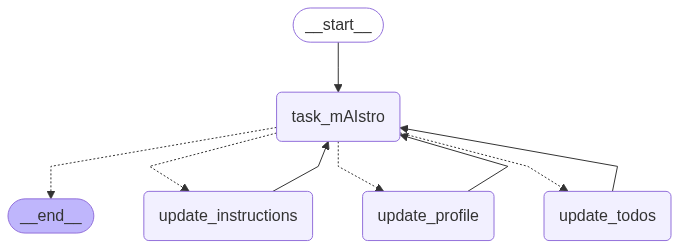

In [64]:
# Build
builder = StateGraph(MessagesState)

# Nodes
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)

# Logic
builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [65]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "Bin"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Bin. I live in Houston doing stuff about AI.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Bin. I live in Houston doing stuff about AI.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_C7odhcNJfb6gcoDIbg5EUXiO)
 Call ID: call_C7odhcNJfb6gcoDIbg5EUXiO
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Got it! How can I assist you today?


In [66]:
# User input for a ToDo
input_messages = [HumanMessage(content="I have a basketball dribbling session to finish today.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have a basketball dribbling session to finish today.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_rdAIfUl3Fe3rY1CH1i45a7N9)
 Call ID: call_rdAIfUl3Fe3rY1CH1i45a7N9
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Complete basketball dribbling session', 'time_to_complete': 60, 'deadline': '2025-08-23T23:59:00', 'status': 'in progress'}
================================== Ai Message ==================================

I've added your basketball dribbling session to your ToDo list. Is there anything else you'd like to add or update?


In [67]:
# User input to update instructions for creating ToDos
input_messages = [HumanMessage(content="When creating or updating ToDo items, include specific local businesses / vendors.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific local businesses / vendors.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_RfA6Gr4xikm8rM2SLrQePNs3)
 Call ID: call_RfA6Gr4xikm8rM2SLrQePNs3
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

I've updated the instructions to include specific local businesses or vendors when creating or updating ToDo items. Is there anything else you'd like to adjust or add?


In [68]:
# Check for updated instructions
user_id = "Bin"

# Search
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': "Based on your feedback, here are the updated instructions for managing ToDo list items:\n\n<current_instructions>\n1. When adding or updating ToDo items, include specific local businesses or vendors if applicable.\n2. Ensure that the task description is clear and concise.\n3. Include relevant details such as deadlines, time to complete, and status.\n4. Confirm with the user if they have any additional preferences or details to include.\n</current_instructions>\n\nIs there anything else you'd like to adjust or add?"}


In [70]:
# User input for a ToDo
input_messages = [HumanMessage(content="I need to test the traction performance of my new GT Cut 1 in the gym.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to test the traction performance of my new GT Cut 1 in the gym.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_gOcwWx9Jm312q5WwYdjzKIgb)
 Call ID: call_gOcwWx9Jm312q5WwYdjzKIgb
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Test traction performance of GT Cut 1 in the gym', 'time_to_complete': 30, 'deadline': '2025-08-24T23:59:00', 'solutions': ['Local gym with basketball court'], 'status': 'not started'}

Document 5c49d245-3391-41f7-b1e7-58391d69c817 updated:
Plan: Add a solution to the existing task to include a local gym with a basketball court.
Added content: Local gym with basketball court
================================== Ai Message ==================================

I've added the task to test the traction performance of yo

In [71]:
# Namespace for the memory to save
user_id = "Bin"

# Search
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Complete basketball dribbling session', 'time_to_complete': 60, 'deadline': '2025-08-23T23:59:00', 'solutions': ['Local gym with basketball court'], 'status': 'in progress'}
{'task': 'Test traction performance of GT Cut 1 in the gym', 'time_to_complete': 30, 'deadline': '2025-08-24T23:59:00', 'solutions': ['Local gym with basketball court'], 'status': 'not started'}


In [72]:
# User input to update an existing ToDo
input_messages = [HumanMessage(content="For the dribbling session, I need to get that done by end of next week.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the dribbling session, I need to get that done by end of next week.
================================== Ai Message ==================================

I've noted that you need to complete the basketball dribbling session by the end of next week. If there's anything else you'd like to update or add, just let me know!


In [74]:
# User input for a ToDo
input_messages = [HumanMessage(content="Need to call back BMW Houston to schedule car wash.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Need to call back BMW Houston to schedule car wash.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_hIPiaTqJHYiLK9w0bAr1xqjF)
 Call ID: call_hIPiaTqJHYiLK9w0bAr1xqjF
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Call back BMW Houston to schedule car wash', 'time_to_complete': 10, 'solutions': ['BMW Houston'], 'status': 'not started'}

Document 5c49d245-3391-41f7-b1e7-58391d69c817 updated:
Plan: Replace the deadline for the basketball dribbling session to the end of next week.
Added content: 2025-08-30T23:59:00
================================== Ai Message ==================================

I've added the task to call back BMW Houston to schedule a car wash to your ToDo list. If there's anything else you need, feel free to let me know!


In [75]:
# Namespace for the memory to save
user_id = "Bin"

# Search
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Complete basketball dribbling session', 'time_to_complete': 60, 'deadline': '2025-08-30T23:59:00', 'solutions': ['Local gym with basketball court'], 'status': 'in progress'}
{'task': 'Test traction performance of GT Cut 1 in the gym', 'time_to_complete': 30, 'deadline': '2025-08-24T23:59:00', 'solutions': ['Local gym with basketball court'], 'status': 'not started'}
{'task': 'Call back BMW Houston to schedule car wash', 'time_to_complete': 10, 'deadline': None, 'solutions': ['BMW Houston'], 'status': 'not started'}


Now we can create a new thread for a new session.

We can check if the Profile, ToDos, and Instructions saved as long-term memory are accessible:

In [76]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "2", "user_id": "Bin"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="What tasks do I have?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What tasks do I have?
================================== Ai Message ==================================

Here are your current tasks:

1. **Complete basketball dribbling session**
   - Time to complete: 60 minutes
   - Deadline: August 30, 2025
   - Solutions: Local gym with basketball court
   - Status: In progress

2. **Test traction performance of GT Cut 1 in the gym**
   - Time to complete: 30 minutes
   - Deadline: August 24, 2025
   - Solutions: Local gym with basketball court
   - Status: Not started

3. **Call back BMW Houston to schedule car wash**
   - Time to complete: 10 minutes
   - Deadline: None
   - Solutions: BMW Houston
   - Status: Not started

Let me know if there's anything you'd like to update or add!


In [77]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Yes, give me some options to call for dribbling training sessions.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, give me some options to call for dribbling training sessions.
================================== Ai Message ==================================

Here are some options you might consider for dribbling training sessions in Houston:

1. **Houston Basketball Academy**
   - Offers personalized training sessions focusing on dribbling and other skills.
   - Website: [houstonbasketballacademy.com](http://houstonbasketballacademy.com)

2. **Pro Skills Basketball - Houston**
   - Provides skill development sessions, including dribbling.
   - Website: [proskillsbasketball.com/houston](https://www.proskillsbasketball.com/houston/)

3. **The Gym**
   - Offers open gym times and training sessions for basketball enthusiasts.
   - Website: [thegymhouston.com](http://thegymhouston.com)

4. **Hoop Generation**
   - Specializes in basketball training with a focus on dribbling and shooting.
   - Website: [hoopgeneration.